# About RBMs

Let us assume we have $d$ visible units and $n$ hidden units.


Energy of an RBM

$$
E(\pmb{x},\pmb{h}) = - \pmb{c}^T \pmb{v} - \pmb{b}^T \pmb{h} - \pmb{h}^T \pmb{W} \pmb{v}
$$

Probability of an assignment of hidden and visible units:

$$
P(v,h) = - \frac{ e^{-E(v,h)} } { \sum_{( \bar{v},\bar{h}) \in \{0,1\}^d x \{0,1\}^n } e^{-E(\bar{v},\bar{h})} }
$$

In [9]:
import sys
import os
import inspect
#sys.path.insert(0,'..')

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent =  os.path.dirname(currentdir) + '/RBM'
sys.path.insert(0,parent)

%load_ext autoreload
%autoreload 2
%matplotlib inline

from timeit import default_timer as timer
import numpy as np
import time
import matplotlib.pyplot as plt
import numexpr  as ne
import profile
import rbm as Rbm
import pandas

## Read the MNIST 

In [10]:
X_ = pandas.read_csv("../Datasets/MNIST/train_mnist.csv")
Y = X_["label"].values
X = X_[X_.columns[1:]].values

del(X_)

print('\t files read')
X = np.array(X>4, dtype ='float32')

saved_models_folder = "saved_models"
visible_dim = X.shape[1]
hidden_dim = 225
epochs = 100
K = 1
lr = 0.1
batch_size = 10

Xaux = np.array(X, dtype='float32')

	 files read


## Defining an RBM


In [11]:
rbm_ = Rbm.RBM(visible_dim=visible_dim,
               hidden_dim=hidden_dim,
               seed=42,
               mu=0, 
               sigma=0.3,
               monitor_time=True)

In [12]:
rbm_.W.shape, rbm_.b.shape, rbm_

((784, 225), (784,), <rbm.RBM at 0xa22015780>)

## Benchmarking `.fit` method (vectorized vs non vectorized)

In [13]:
Xaux = np.array(Xaux, dtype="float64")

In [229]:
%%time
rbm_.fit(Xaux, 
         method='CDK',
         K=K,
         lr=lr,
         epochs=1,
         batch_size=128,
         plot_weights=False)

	Last epoch: 0 	time per epoch: 35.47	total time: 35.48
	Training finished


CPU times: user 35.2 s, sys: 1.3 s, total: 36.5 s
Wall time: 35.5 s


In [230]:
%%time
rbm_.fit(Xaux, 
         method='vectorized_CDK',
         K=K,
         lr=0.01,
         epochs=1,
         batch_size=128,
         plot_weights=False)

	Last epoch: 0 	time per epoch: 2.42	total time: 2.42
	Training finished


CPU times: user 3.89 s, sys: 604 ms, total: 4.49 s
Wall time: 2.42 s


## Training multiple epochs and showing the weights

In [14]:
rbm_ = Rbm.RBM(visible_dim=visible_dim,
               hidden_dim=hidden_dim,
               seed=42,
               mu=0, 
               sigma=0.3,
               monitor_time=True)

In [15]:
%%time
rbm_.fit(Xaux, 
         method='vectorized_CDK',
         K=K,
         lr=0.01,
         epochs=300,
         batch_size=128,
         plot_weights=False)

	Last epoch: 299 	time per epoch: 2.30	total time: 716.94
	Training finished


CPU times: user 19min 28s, sys: 3min 7s, total: 22min 35s
Wall time: 11min 56s


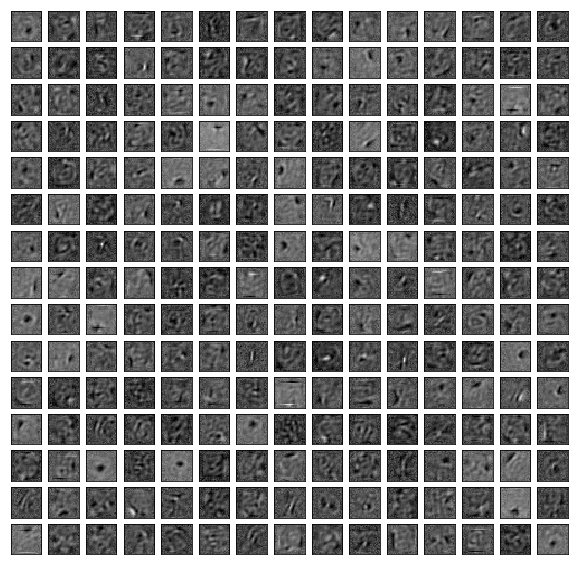

In [16]:
rbm_.plot_weights(min_max_scale = True)

#### Saving the model with joblib

In [327]:
import joblib

# save the classifier
#joblib.dump(rbm_, filename="./saved_models/rbm.pkl")    

# load it again
#rbm2 = joblib.load("./saved_models/rbm.pkl")

In [237]:
#plt.imshow(rbm2.W[:,3].reshape(28,28), cmap="gray")

## Using the model as a feature generation machine

In [238]:
import sklearn
from sklearn import ensemble
from sklearn import linear_model
import pandas
import numpy as np

In [239]:
X_ = pandas.read_csv("../Datasets/MNIST/train_mnist.csv")
Y = X_["label"].values
X = X_[X_.columns[1:]].values

In [240]:
model = sklearn.linear_model.Perceptron(max_iter = 50)
model.fit(X,Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=50, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [241]:
print("train accuracy:",np.mean(Y==model.predict(X)))

train accuracy: 0.889904761905


#### Learn perceptron on top of Features given by the RBM

In [242]:
X_features_rbm = rbm_.propup(X)

In [243]:
model = sklearn.linear_model.Perceptron(max_iter = 50)
model.fit(X_features_rbm ,Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=50, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [244]:
print("train accuracy:",np.mean(Y==model.predict(X_features_rbm )))

train accuracy: 0.918928571429


## Sampling from an RBM

#### Sampling from a hidden state configuration

In [280]:
np.random.seed(123)
h_hat = np.array([np.random.randint(2) for i in range(rbm_.hidden_dim)])

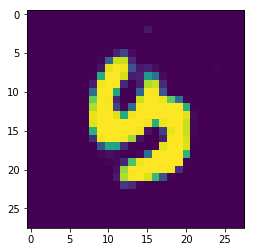

In [287]:
x_hat, x_hat_p = rbm_.sample_visible_from_hidden(h_hat, n_gibbs=2000)
plt.imshow(x_hat.reshape(28,28))
plt.imshow(x_hat_p.reshape(28,28))

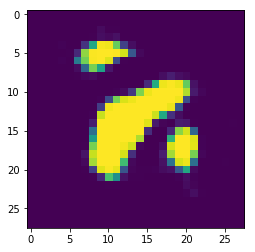

In [288]:
x_hat = sample_from_hidden(h_hat,rbm_, n_gibbs=2000)
plt.imshow(x_hat.reshape(28,28))

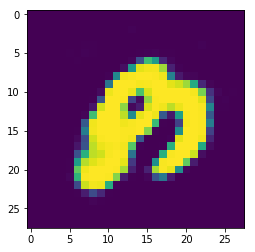

In [289]:
x_hat = sample_from_hidden(h_hat,rbm_, n_gibbs=2000)
plt.imshow(x_hat.reshape(28,28))

#### sampling starting form a visible vector

In [293]:
X[1,:].shape

(784,)

In [299]:
x = X[1,:]
x_hat, x_hat_p = rbm_.sample_visible_from_visible(x, n_gibbs=10)

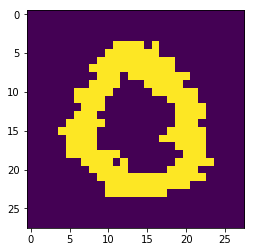

In [304]:
plt.imshow(x_hat.reshape(28,28))

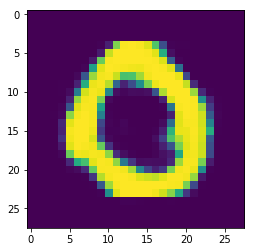

In [305]:
plt.imshow(x_hat_p.reshape(28,28))

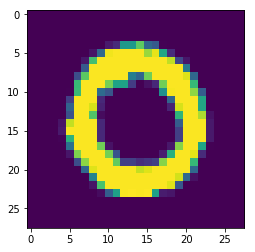

In [303]:
plt.imshow(x.reshape(28,28))

### Dreaming from a visible sample

The following code has an issue: ** it generates new samples at every frame form the same visisble vector x**. Therefore, keep in mind the animation shows "how samples look like (the reconstruction of x after n_gibbs steps) starting in x".


We would like to have a version where **x is updated**.

You need to install `ffmpeg`:

```
conda install -c conda-forge ffmpeg
```


In [178]:
import scipy.misc
import matplotlib.animation as animation
import numpy as np
from pylab import *

def generate_movie(x, update_frame_func, n_steps, movie_name, dpi = 100):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title("la")
    
    im = ax.imshow(x.reshape(28,28), cmap='gray',interpolation='nearest')
    im.set_clim([0,1])
    fig.set_size_inches([5,5])
    tight_layout()
    
    def func(n, x):
        # We would like to make a plot of the "evolving process" 
        # This print below shows same visible vector is used
        # How can we change this??
        # print(n, x.sum())
        x, x_hat_p = rbm_.sample_visible_from_visible(x, n_gibbs=5)
        #import pdb;pdb.set_trace()  
        im.set_data(x_hat_p.reshape(28,28))
        return x
    
    #legend(loc=0)
    ani = animation.FuncAnimation(fig, func, n_steps, interval=30, fargs=[x])
    writer = animation.writers['ffmpeg'](fps=30)

    ani.save(movie_name + '.mp4', writer=writer, dpi=dpi)
    return ani

0 241.0
0 241.0
1 241.0
2 241.0
3 241.0
4 241.0
5 241.0
6 241.0
7 241.0
8 241.0
9 241.0
10 241.0
11 241.0
12 241.0
13 241.0
14 241.0
15 241.0
16 241.0
17 241.0
18 241.0
19 241.0
20 241.0
21 241.0
22 241.0
23 241.0
24 241.0
25 241.0
26 241.0
27 241.0
28 241.0
29 241.0
30 241.0
31 241.0
32 241.0
33 241.0
34 241.0
35 241.0
36 241.0
37 241.0
38 241.0
39 241.0
40 241.0
41 241.0
42 241.0
43 241.0
44 241.0
45 241.0
46 241.0
47 241.0
48 241.0
49 241.0
50 241.0
51 241.0
52 241.0
53 241.0
54 241.0
55 241.0
56 241.0
57 241.0
58 241.0
59 241.0
60 241.0
61 241.0
62 241.0
63 241.0
64 241.0
65 241.0
66 241.0
67 241.0
68 241.0
69 241.0
70 241.0
71 241.0
72 241.0
73 241.0
74 241.0
75 241.0
76 241.0
77 241.0
78 241.0
79 241.0
80 241.0
81 241.0
82 241.0
83 241.0
84 241.0
85 241.0
86 241.0
87 241.0
88 241.0
89 241.0
90 241.0
91 241.0
92 241.0
93 241.0
94 241.0
95 241.0
96 241.0
97 241.0
98 241.0
99 241.0


0 241.0


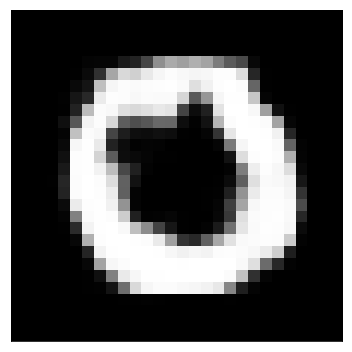

In [179]:
original_frame = X[1,:]
n_steps = 100
movie_name = "dreaming_from_a_training_sample"
generate_movie(original_frame, update_frame_func, n_steps, movie_name, dpi = 100)

In [177]:
?animation.FuncAnimation